In [26]:
import tensorflow as tf
from tensorflow import keras

In [27]:
import numpy as np
import os

## Sentiment Analysis

### loading IMDb reviews using TensorFlow Datasets

In [28]:
#downloading dataset imdb_reviews to C:\Users\josef\tensorflow_datasets\imdb_reviews\...

In [29]:
import tensorflow_datasets as tfds

train_ds, info_train = tfds.load('imdb_reviews', split='train[:80%]', as_supervised=True, with_info=True)
val_ds, info_val = tfds.load('imdb_reviews', split='train[80%:]', as_supervised=True, with_info=True)

In [30]:
train_size = info_train.splits["train[:80%]"].num_examples; train_size

20000

In [31]:
val_size = info_val.splits["train[80%:]"].num_examples; val_size

5000

In [32]:
#preprocessing: text data restricted to 500 words

In [33]:
maxwordlen = 500  #max word length for each review
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 3000)  #delimiting string to 3000 characters which relates to max 589 words
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch, maxsplit=maxwordlen)[:,:maxwordlen] #split string into words; #words restricted
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch  #batch will be filled with padding token

In [34]:
#build up vocabulary from text data

In [35]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in train_ds.batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [36]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [37]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [38]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [39]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

In [40]:
train_set = train_ds.repeat().batch(32).map(preprocess)  #batches with 32 reviews are going to be preprocessed
train_set = train_set.map(encode_words).prefetch(1)      #tokenization: encode words to integer

val_set = val_ds.repeat().batch(32).map(preprocess)
val_set = val_set.map(encode_words).prefetch(1)

In [41]:
#calculate maximum number of words for each review

In [42]:
i=0
max_dim=np.array([])
for data in train_ds.batch(32).map(preprocess).map(encode_words).batch(1):
    i+=1
    max_dim = np.append(max_dim, np.count_nonzero(data[0].numpy()[0], axis=1).max())

In [43]:
max_dim.shape, max_dim.max()  #maximum number of words of all reviews

((625,), 500.0)

In [44]:
#calculate maximum number of out-of-vocabulary (oov) buckets

In [45]:
i=0
max_oov=np.array([])
for data in train_ds.batch(32).map(preprocess).map(encode_words).batch(1):
    i+=1
    count_oov = np.count_nonzero(data[0].numpy()[0]>10000, axis=1)  #count elements along columns with x>10000; return array with 32 values;
    max_oov = np.append(max_oov, count_oov.max())

In [46]:
max_oov.shape, max_oov.max()  #x out of 1000 out-of-vocabulary (oov) buckets are occupied

((625,), 122.0)

### training recurrent network: stacked GRU

In [47]:
#model.summary()

In [48]:
#keras.utils.plot_model(model, show_shapes=True)

In [49]:
#LSTM layer expects inputs to have shape of (batch_size, timesteps, input_dim)

In [50]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size+num_oov_buckets, embed_size, mask_zero=True),  #default: mask_zero=False
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=train_size // 32, 
                    epochs=10,
                    validation_data=val_set,
                    validation_steps=val_size // 32 )

Epoch 1/10
625/625 [==============================] - 3256s 5s/step - loss: 0.5079 - accuracy: 0.7534 - val_loss: 0.3634 - val_accuracy: 0.8411
Epoch 2/10
625/625 [==============================] - 3964s 6s/step - loss: 0.3124 - accuracy: 0.8765 - val_loss: 0.2924 - val_accuracy: 0.8818
Epoch 3/10
625/625 [==============================] - 4416s 7s/step - loss: 0.2071 - accuracy: 0.9224 - val_loss: 0.3000 - val_accuracy: 0.8770
Epoch 4/10
625/625 [==============================] - 4159s 7s/step - loss: 0.1490 - accuracy: 0.9457 - val_loss: 0.3838 - val_accuracy: 0.8598
Epoch 5/10
625/625 [==============================] - 4120s 7s/step - loss: 0.1091 - accuracy: 0.9625 - val_loss: 0.3982 - val_accuracy: 0.8628
Epoch 6/10
625/625 [==============================] - 4246s 7s/step - loss: 0.0740 - accuracy: 0.9757 - val_loss: 0.3975 - val_accuracy: 0.8680
Epoch 7/10
625/625 [==============================] - 4105s 7s/step - loss: 0.0495 - accuracy: 0.9847 - val_loss: 0.4667 - val_accuracy:

### evaluating model

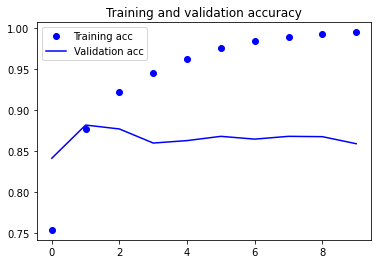

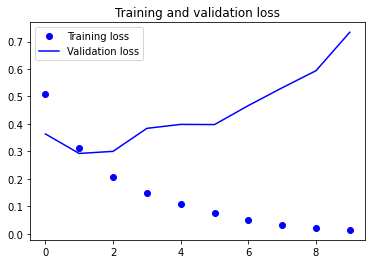

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
import numpy as np
np.argmax(val_acc)+1

2

In [53]:
round(val_acc[np.argmax(val_acc)],2)

0.88